In [1]:
import pandas as pd
import tensorflow as tf
import keras as ks
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.metrics import recall_score, confusion_matrix
from scripts.model_functions import *
from scripts.helper_functions import *
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Flatten, Activation

Using TensorFlow backend.


In [26]:
# Create new variables to be used in Keras and the CNN

# number of items to use for training
BATCH_SIZE = 400 

# number of times to repeat process
EPOCHS = 100

# how many points ahead to look
POINTS_AHEAD = 0


In [3]:
# Load the data
df = pd.read_csv('../../data/cleaned/site1_vineyard.csv')
df.head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,4.4,1.3,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,4.2,1.2,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,4.3,1.3,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,4.5,1.3,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,4.5,1.3,89.8,9.02,0.4


In [4]:
# Adding time stamp 
from datetime import datetime

timestamp = df['Date (mm.dd.yyyy)'] + ' '+ df['Time 24hr']
timestamp = pd.to_datetime(timestamp)
df['Timestamp'] = timestamp
df.head()
#converts the date object to a numerical representation of that object
#dataset['date (mm.dd.yyyy)'] = (dataset['date (mm.dd.yyyy)'] - dataset['date (mm.dd.yyyy)'].min()) / np.timedelta64(1,'D')
#dataset.dtypes

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,Timestamp
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,4.4,1.3,90.2,9.04,0.4,2017-05-05 00:00:00
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,4.2,1.2,90.2,9.04,0.4,2017-05-05 00:15:00
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,4.3,1.3,90.1,9.04,0.4,2017-05-05 00:30:00
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,4.5,1.3,90.0,9.03,0.4,2017-05-05 00:45:00
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,4.5,1.3,89.8,9.02,0.4,2017-05-05 01:00:00


In [5]:
# dont need data and time now that we have Timestamp. Lets remove them

df = df.drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
df.head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,Timestamp
0,15.02,1848,-100.1,8.36,16.84,4.4,1.3,90.2,9.04,0.4,2017-05-05 00:00:00
1,14.99,1847,-100.1,8.36,16.76,4.2,1.2,90.2,9.04,0.4,2017-05-05 00:15:00
2,14.96,1847,-100.1,8.36,16.82,4.3,1.3,90.1,9.04,0.4,2017-05-05 00:30:00
3,14.95,1848,-100.1,8.36,17.19,4.5,1.3,90.0,9.03,0.4,2017-05-05 00:45:00
4,14.92,1848,-100.0,8.36,16.85,4.5,1.3,89.8,9.02,0.4,2017-05-05 01:00:00


In [6]:
# lets try to normalize this now....
target = df['BGA-Phycocyanin RFU']
dataset_columns = ['Temp C','Sp Cond (uS/cm)', 'pH (mV)','pH', 'Turbidity (NTU)', 'ODOSat%','ODO (mg/L)','Chlorophyll RFU']
scaler = MinMaxScaler()
ds_scaled = scaler.fit_transform(df[dataset_columns])
df = pd.DataFrame(ds_scaled,columns=dataset_columns)
df['BGA-Phycocyanin RFU'] = target
df.describe()

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),Chlorophyll RFU,BGA-Phycocyanin RFU
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,0.560516,0.893366,0.477889,0.541089,0.090355,0.165126,0.273546,0.097225,0.979511
std,0.267413,0.070246,0.116241,0.113254,0.085879,0.093899,0.116220,0.063135,0.731423
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.308195,0.853771,0.426166,0.461538,0.045893,0.117086,0.190000,0.051852,0.500000
50%,0.640366,0.895882,0.492228,0.553846,0.065216,0.138870,0.264545,0.085185,0.900000
75%,0.784656,0.956502,0.538860,0.592308,0.102407,0.177672,0.370909,0.125926,1.200000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.100000


In [27]:
dataset_columns = ['Temp C','Sp Cond (uS/cm)', 'pH (mV)','pH', 'Turbidity (NTU)', 'ODOSat%','ODO (mg/L)', 'Chlorophyll RFU']
(segments, labels) = segment_dataset(df, dataset_columns , 'BGA-Phycocyanin RFU', 7, pts_ahead=POINTS_AHEAD)
print('done')


WINDOW SIZE 7
NUMBER OF COULUMNS 8
LOOKING AHEAD 0 points
Window Segmentation 0.56% done
Window Segmentation 1.09% done
Window Segmentation 1.62% done
Window Segmentation 2.15% done
Window Segmentation 2.68% done
Window Segmentation 3.20% done
Window Segmentation 3.73% done
Window Segmentation 4.26% done
Window Segmentation 4.79% done
Window Segmentation 5.31% done
Window Segmentation 5.84% done
Window Segmentation 6.37% done
Window Segmentation 6.90% done
Window Segmentation 7.43% done
Window Segmentation 7.95% done
Window Segmentation 8.48% done
Window Segmentation 9.01% done
Window Segmentation 9.54% done
Window Segmentation 10.06% done
Window Segmentation 10.59% done
Window Segmentation 11.12% done
Window Segmentation 11.65% done
Window Segmentation 12.18% done
Window Segmentation 12.70% done
Window Segmentation 13.23% done
Window Segmentation 13.76% done
Window Segmentation 14.29% done
Window Segmentation 14.82% done
Window Segmentation 15.34% done
Window Segmentation 15.87% done


In [28]:
print("Before (18940, 7, 8)")
print("After {}".format(segments.shape))

segments.shape

Before (18940, 7, 8)
After (18940, 7, 8)


(18940, 7, 8)

In [29]:
print("Before (18940,)")
print("After {}".format(labels.shape))
labels.shape

Before (18940,)
After (18940,)


(18940,)

In [30]:
labels[0]

0.4

In [31]:
labels[0]

0.4

## Shaping the data to be used in the model.

In [32]:
segments = segments.reshape(len(segments),7,8)
segments.shape

(18940, 7, 8)

In [33]:
print(segments[0])

[[0.40932868 0.8537714  0.69430052 0.33076923 0.02543865 0.18652144
  0.35181818 0.04814815]
 [0.40802092 0.85330865 0.69430052 0.33076923 0.02531287 0.18652144
  0.35181818 0.04444444]
 [0.40671316 0.85330865 0.69430052 0.33076923 0.02540721 0.18584071
  0.35181818 0.04814815]
 [0.40627724 0.8537714  0.69430052 0.33076923 0.02598893 0.18515997
  0.35090909 0.04814815]
 [0.40496949 0.8537714  0.69559585 0.33076923 0.02545437 0.1837985
  0.35       0.04814815]
 [0.40496949 0.8546969  0.69430052 0.33076923 0.02479404 0.1837985
  0.35       0.05185185]
 [0.40409765 0.85515965 0.69430052 0.33076923 0.02466826 0.18311777
  0.34909091 0.04814815]]


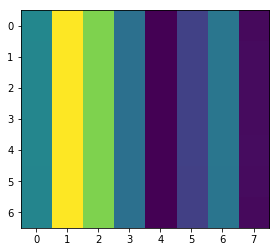

In [34]:
plt.imshow(segments[1])

## Breaking apart training and test data

In [35]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(segments, labels, test_size=0.25)

In [36]:
print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (14205, 7, 8)
x_test shape: (4735, 7, 8)
y_train shape: (14205,)
y_test shape: (4735,)


In [37]:
if POINTS_AHEAD > 0:
    y_train = y_train.reshape(y_train.shape[0],y_train.shape[1])
    y_test = y_test.reshape(y_test.shape[0],y_test.shape[1])
else:
    y_train = y_train.reshape(y_train.shape[0], 1)
    y_test = y_test.reshape(y_test.shape[0], 1)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

y_train shape: (14205, 1)
y_test shape: (4735, 1)


In [38]:
# Gets the precision of the different metrics
def create_class_predictions(pred):
    retval = np.array([])
    for row in pred:
        max_value = (-1,-1)
        for index, value in enumerate(row):
            if value > max_value[1]:
                max_value = (index, value)
        retval = np.append(retval, max_value[0])
    return retval

## Build the CNN model

The determining factor of a CNN model is at least one Convolutional layer in the model. so lets try to build something to see what kind of metrics that we are getting. 

In [96]:
model = Sequential()
model.add(Conv1D(40,kernel_size=(4),input_shape=(x_test.shape[1],x_test.shape[2])))
model.add(Dense(40))
model.add(Dropout(0.2))
model.add(Dense(20))
model.add(Flatten())
model.add(Dense(y_test.shape[1]))
model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['mse']
             )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 4, 40)             1320      
_________________________________________________________________
dense_16 (Dense)             (None, 4, 40)             1640      
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 40)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 4, 20)             820       
_________________________________________________________________
flatten_6 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 81        
Total params: 3,861
Trainable params: 3,861
Non-trainable params: 0
_________________________________________________________________


In [97]:
print(y_test[0])

[0.5]


In [98]:
model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)
# What is our score?

score = model.evaluate(x_test, y_test, verbose=1)
cnn_predictions = model.predict(x_test)
print("Loss {} MSE {}".format(score[0], score[1]))

Epoch 1/100
14205/14205 [==============================] - 1s 59us/step - loss: 0.5012 - mean_squared_error: 0.5012
Epoch 2/100
14205/14205 [==============================] - 0s 11us/step - loss: 0.3888 - mean_squared_error: 0.3888
Epoch 3/100
14205/14205 [==============================] - 0s 13us/step - loss: 0.3771 - mean_squared_error: 0.3771
Epoch 4/100
14205/14205 [==============================] - 0s 13us/step - loss: 0.3669 - mean_squared_error: 0.3669
Epoch 5/100
14205/14205 [==============================] - 0s 12us/step - loss: 0.3760 - mean_squared_error: 0.3760
Epoch 6/100
14205/14205 [==============================] - 0s 13us/step - loss: 0.3623 - mean_squared_error: 0.3623
Epoch 7/100
14205/14205 [==============================] - 0s 18us/step - loss: 0.3616 - mean_squared_error: 0.3616
Epoch 8/100
14205/14205 [==============================] - 0s 14us/step - loss: 0.3636 - mean_squared_error: 0.3636
Epoch 9/100
14205/14205 [==============================] - 0s 12us/step 

14205/14205 [==============================] - 0s 9us/step - loss: 0.3399 - mean_squared_error: 0.3399
Epoch 72/100
14205/14205 [==============================] - 0s 9us/step - loss: 0.3431 - mean_squared_error: 0.3431
Epoch 73/100
14205/14205 [==============================] - 0s 11us/step - loss: 0.3408 - mean_squared_error: 0.3408
Epoch 74/100
14205/14205 [==============================] - 0s 10us/step - loss: 0.3394 - mean_squared_error: 0.3394
Epoch 75/100
14205/14205 [==============================] - 0s 10us/step - loss: 0.3404 - mean_squared_error: 0.3404
Epoch 76/100
14205/14205 [==============================] - 0s 10us/step - loss: 0.3423 - mean_squared_error: 0.3423
Epoch 77/100
14205/14205 [==============================] - 0s 9us/step - loss: 0.3380 - mean_squared_error: 0.3380
Epoch 78/100
14205/14205 [==============================] - 0s 9us/step - loss: 0.3393 - mean_squared_error: 0.3393
Epoch 79/100
14205/14205 [==============================] - 0s 9us/step - loss: 0

## Building a regression model

Experimenting to see if a regression model will help with doing predicting a 

In [99]:
model = Sequential()
model.add(Dense(40, input_shape=(x_test.shape[1],x_test.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(20))
model.add(Flatten())
model.add(Dense(y_test.shape[1]))
model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['mse']
             )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 7, 40)             360       
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 40)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 7, 20)             820       
_________________________________________________________________
flatten_7 (Flatten)          (None, 140)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 141       
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________


In [100]:
model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)
# What is our score?
score = model.evaluate(x_test, y_test, verbose=1)
linear_predictions = model.predict(x_test)
print("Loss {} MSE {}".format(score[0], score[1]))

Epoch 1/100
14205/14205 [==============================] - 1s 50us/step - loss: 0.7444 - mean_squared_error: 0.7444
Epoch 2/100
14205/14205 [==============================] - 0s 11us/step - loss: 0.4581 - mean_squared_error: 0.4581
Epoch 3/100
14205/14205 [==============================] - 0s 11us/step - loss: 0.3974 - mean_squared_error: 0.3974
Epoch 4/100
14205/14205 [==============================] - 0s 10us/step - loss: 0.3777 - mean_squared_error: 0.3777
Epoch 5/100
14205/14205 [==============================] - 0s 9us/step - loss: 0.3709 - mean_squared_error: 0.3709
Epoch 6/100
14205/14205 [==============================] - 0s 9us/step - loss: 0.3600 - mean_squared_error: 0.3600
Epoch 7/100
14205/14205 [==============================] - 0s 10us/step - loss: 0.3573 - mean_squared_error: 0.3573
Epoch 8/100
14205/14205 [==============================] - 0s 10us/step - loss: 0.3563 - mean_squared_error: 0.3563
Epoch 9/100
14205/14205 [==============================] - 0s 9us/step - l

14205/14205 [==============================] - 0s 9us/step - loss: 0.3375 - mean_squared_error: 0.3375
Epoch 72/100
14205/14205 [==============================] - 0s 9us/step - loss: 0.3372 - mean_squared_error: 0.3372
Epoch 73/100
14205/14205 [==============================] - 0s 9us/step - loss: 0.3383 - mean_squared_error: 0.3383
Epoch 74/100
14205/14205 [==============================] - 0s 9us/step - loss: 0.3401 - mean_squared_error: 0.3401
Epoch 75/100
14205/14205 [==============================] - 0s 10us/step - loss: 0.3384 - mean_squared_error: 0.3384
Epoch 76/100
14205/14205 [==============================] - 0s 9us/step - loss: 0.3387 - mean_squared_error: 0.3387
Epoch 77/100
14205/14205 [==============================] - 0s 9us/step - loss: 0.3376 - mean_squared_error: 0.3376
Epoch 78/100
14205/14205 [==============================] - 0s 9us/step - loss: 0.3366 - mean_squared_error: 0.3366
Epoch 79/100
14205/14205 [==============================] - 0s 9us/step - loss: 0.33

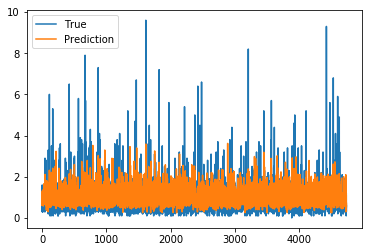

In [101]:
lines = pd.DataFrame({'True':y_test.reshape(y_test.shape[0]), 'Prediction':linear_predictions.reshape(linear_predictions.shape[0])})
lines.plot()

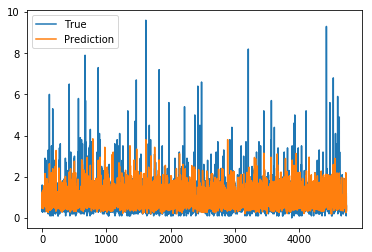

In [102]:
lines = pd.DataFrame({'True':y_test.reshape(y_test.shape[0]), 'Prediction':cnn_predictions.reshape(cnn_predictions.shape[0])})
lines.plot()